In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
np.random.seed(1)
tf.random.set_seed(1)

In [8]:
# hyper parameter
LEARNING_RATE = 0.005
N_EPOCHS = 100
N_BATCHS = 100
N_CLASS = 10
DROPOUT_RATE = 0.3

In [9]:
label = ['비행기','자동차','새','고양이','사슴','개','개구리','말','배','트럭']
label_eng = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
# 다운로드 받는다.
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [11]:
# 32 * 32 * 3
train_image.shape, test_image.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [12]:
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

In [13]:
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [14]:
train_label[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

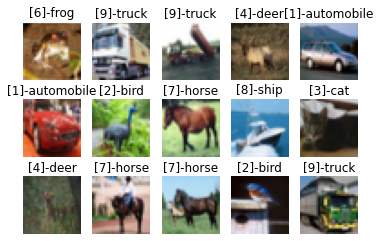

In [15]:
import matplotlib.pyplot as plt
for i in range(0,15):
    plt.subplot(3,5, i+1)
    plt.imshow(train_image[i])
    plt.axis('off')
    plt.title(f'{train_label[i]}-{label_eng[train_label[i,0]]}')
plt.show()    

# Dataset 생성

In [16]:
# pixel값을 0 ~ 1 사이로 조정
X_train = train_image.astype(np.float32)/255.
X_test = test_image.astype(np.float32) /255.

# y - onehot encoding
y_train = keras.utils.to_categorical(train_label, num_classes=10)
y_test = keras.utils.to_categorical(test_label, 10) 

In [17]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(buffer_size=N_TRAIN)\
                               .batch(N_BATCHS,drop_remainder=True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
                              .batch(N_BATCHS)                        

## 모델 구성

In [18]:
from tensorflow.keras import layers
def create_model():
    model = keras.Sequential()
    #Conv Layer
    model.add(layers.Input((32,32,3))) #InputLayer(input_shape=(32,32,3)) : 동일
    
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))
    
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))

 
    # Full Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(DROPOUT_RATE))
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())    
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [19]:
# model = create_model()
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

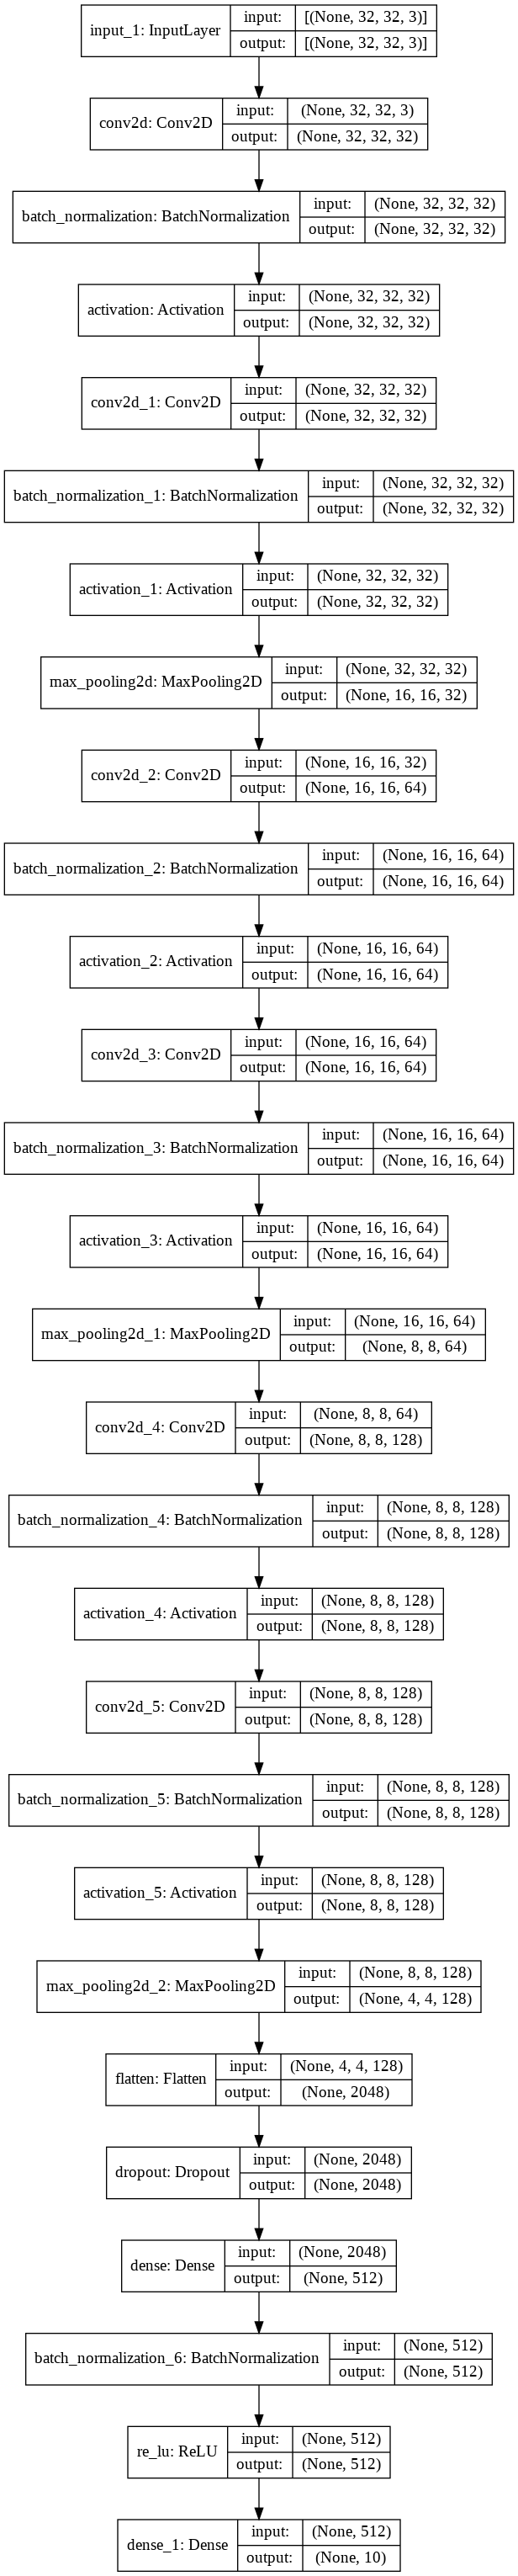

In [20]:
keras.utils.plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [21]:
# 학습 전에 테스트
model.evaluate(test_dataset)

100/100 [==============================] - 33s 6ms/step - loss: 2.3032 - accuracy: 0.0939


[2.303159475326538, 0.09120000153779984]

In [22]:
# 학습시 전달할 매개변수
steps_per_epoch = N_TRAIN//N_BATCHS
validation_steps = int(np.ceil(N_TEST/N_BATCHS))
print(steps_per_epoch, validation_steps)

500 100


In [23]:
import os
base_dir = '/content/drive/MyDrive/save_models'
save_path = os.path.join(base_dir, 'cifar10_best_model')
save_path

'/content/drive/MyDrive/save_models/cifar10_best_model'

In [24]:
# 1970년 1월 1일 0시 0분 0초부터 실행시점까지를 초단위로 계산해서 변환
import time
time.time()

1620379629.267325

In [25]:
import time
start = time.time()
modelcheckpoint_callback = keras.callbacks.ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)

history = model.fit(train_dataset, 
                    epochs=N_BATCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_steps,
                    callbacks=[modelcheckpoint_callback])
end = time.time()

Epoch 1/100
500/500 [==============================] - 9s 15ms/step - loss: 1.2856 - accuracy: 0.5429 - val_loss: 1.8781 - val_accuracy: 0.4262
INFO:tensorflow:Assets written to: /content/drive/MyDrive/save_models/cifar10_best_model/assets
Epoch 2/100
500/500 [==============================] - 8s 15ms/step - loss: 0.8045 - accuracy: 0.7175 - val_loss: 0.9409 - val_accuracy: 0.6766
INFO:tensorflow:Assets written to: /content/drive/MyDrive/save_models/cifar10_best_model/assets
Epoch 3/100
500/500 [==============================] - 8s 15ms/step - loss: 0.6298 - accuracy: 0.7802 - val_loss: 1.1416 - val_accuracy: 0.6208
Epoch 4/100
500/500 [==============================] - 8s 15ms/step - loss: 0.5176 - accuracy: 0.8187 - val_loss: 0.7938 - val_accuracy: 0.7306
INFO:tensorflow:Assets written to: /content/drive/MyDrive/save_models/cifar10_best_model/assets
Epoch 5/100
500/500 [==============================] - 8s 15ms/step - loss: 0.4331 - accuracy: 0.8468 - val_loss: 0.8117 - val_accuracy:

In [26]:
(end-start)/60

13.237237167358398

In [27]:
saved_model = keras.models.load_model(save_path)

In [28]:
saved_model.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.5730 - accuracy: 0.8123


[0.5729504823684692, 0.8123000264167786]

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

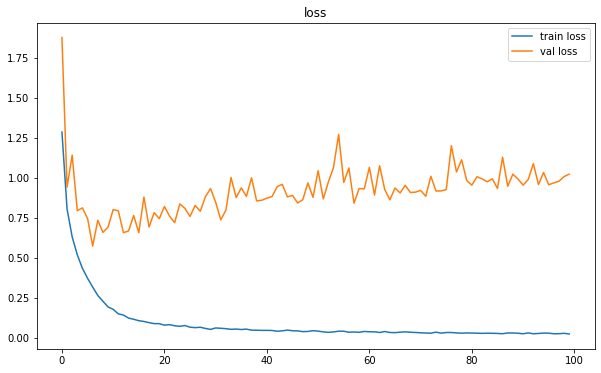

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='val loss')
plt.legend()
plt.title('loss')
plt.show()

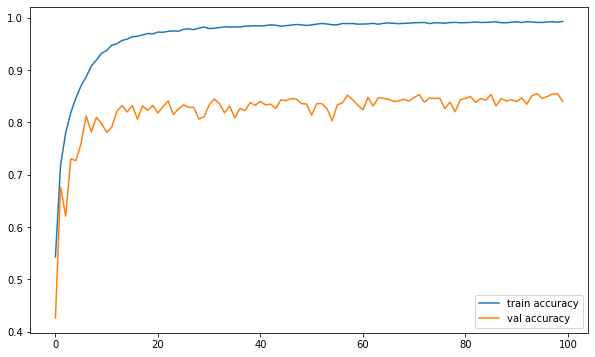

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(N_EPOCHS), history.history['accuracy'], label='train accuracy')
plt.plot(range(N_EPOCHS), history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

<class 'PIL.Image.Image'>


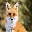

In [48]:
# 새 이미지를 모델을 이용해 추론
# 전처리 학습 데이터와 동일하게 해줘야 함
# 32, 32로 resize. 정규화(255, 나누기)
# load_img 함수: 이미지 불러오기
# img_to_array 함수: 불러온 이미지를 numpy 배열(ndarray)로 변환
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# local에서 사용하려면 Pillow 설치해야됨 - pip install Pillow
# img_path = '/content/truck.pjg.jpeg'
img_path = '/content/fox.jpg'
# img = load_img(img_path) # 원본 그대로 읽어오기
# target_size 지정: 읽어올때, resize처리
img = load_img(img_path, target_size = (32,32))
print(type(img))
img

In [49]:
# ndarray로 변환
sample = img_to_array(img)
type(sample), sample.shape

(numpy.ndarray, (32, 32, 3))

In [50]:
# batch 크기 축(0번축) 늘리기
sample_x = sample[np.newaxis, ...]
sample_x = sample_x / 255
print(sample_x.shape)

(1, 32, 32, 3)


In [51]:
# 추론
pred = saved_model.predict(sample_x)

In [52]:
pred

array([[2.2676708e-03, 5.3821900e-04, 4.8046313e-02, 7.6481509e-01,
        4.6439245e-02, 1.2506568e-01, 3.6087530e-03, 2.2151349e-03,
        3.7118876e-05, 6.9668149e-03]], dtype=float32)

In [53]:
pred_class = np.argmax(pred, axis = 1)
print(pred_class,label[pred_class[0]])

[3] 고양이
